In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import os
from skimage import io, transform
import pandas as pd
import time
import copy
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from tqdm import tqdm
import sklearn.metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Set up the neural network 

In [2]:
class MeltPoolNetwork(nn.Module):
    """Neural Network for Melt Pool Shape Prediction"""
    
    def __init__(self, imageModel, num_classes=10, num_param=10):
        """
        Args:
            imageModel (A pytorch model): the CNN to use for melt pool image encoding
            num_classes (int): Number of different melt pool classes to predict
            num_param (int): Number of process parameters available
        """
        
        super().__init__()
        # The image encoder CNN
        self.ImageModel = imageModel
        
        # The process parameter encoder layers
        self.paramLayer1 = nn.Sequential(nn.Linear(num_param, 10), nn.Tanh())
        self.paramLayer2 = nn.Sequential(nn.Linear(10, 10), nn.Tanh())
        self.paramLayer3 = nn.Sequential(nn.Linear(10, 10), nn.Tanh())
        self.paramLayer4 = nn.Sequential(nn.Linear(10, 10), nn.Tanh())
        
        # prediction head layers
        self.prediction1 = nn.Sequential(nn.Linear(512+10, 100), nn.Tanh())
        self.prediction2 = nn.Linear(100, num_classes)
#         self.prediction = nn.Linear(512+10, num_classes)

        # Initialize Model Weights
        tanh_gain = torch.nn.init.calculate_gain('tanh', param=None)
        torch.nn.init.xavier_normal_(self.paramLayer1[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.paramLayer2[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.paramLayer3[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.paramLayer4[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.prediction1[0].weight, gain=tanh_gain)
        torch.nn.init.kaiming_normal_(self.prediction2.weight, a=0, mode='fan_in', nonlinearity='relu')

    def forward(self, img, pp):
        """
        Args:
            img (tensor): The melt pool image
            pp  (tensor): The process parameters
        """
        
        # Image CNN
        x = self.ImageModel(img)

        # PP NN
        y = self.paramLayer1(pp)
        y = self.paramLayer2(y)
        y = self.paramLayer3(y)
        y = self.paramLayer4(y)
        y = y.view(y.size(0), -1)

        # Prediction Head
        y = torch.squeeze(y)  # remove any dimensions of 1
        z = torch.cat((x, y), dim=1)
        z = self.prediction1(z)
        z = self.prediction2(z)
#         z = self.prediction(z)
        return z

In [3]:
class MeltPoolNetwork_ImageOnly(nn.Module):
    """Neural Network for Melt Pool Shape Prediction"""
    
    def __init__(self, imageModel, num_classes=10, num_param=10):
        """
        Args:
            imageModel (A pytorch model): the CNN to use for melt pool image encoding
            num_classes (int): Number of different melt pool classes to predict
            num_param (int): Number of process parameters available
        """
        
        super().__init__()
        # The image encoder CNN
        self.ImageModel = imageModel

    def forward(self, img, pp):
        """
        Args:
            img (tensor): The melt pool image
            pp  (tensor): The process parameters
        """
        
        # Image CNN
        x = self.ImageModel(img)

        return x

### Set up the dataset/dataloader 

In [4]:
class MeltpoolDataset(Dataset):
    """Dataset for Meltpool Images and Process Parameters"""

    def __init__(self, xlsx_file, root_dir, transform=None):
        """
        Args:
            xlsx_file (string): file with process parameters and labels
            root_dir (string): image directory
            transform (callable, optional): transform(s) to apply
        """

        print('************** Loading Data **************')
        print(xlsx_file)
        
        # Load the excel file and separate into image file names, labels, and process parameters
        if xlsx_file.find('xlsx') >= 0:
            data_frame = pd.read_excel(xlsx_file, sheet_name='Sheet1', engine='openpyxl')
        elif xlsx_file.find('csv')>= 0:
            data_frame = pd.read_csv(xlsx_file)
        self.images = np.array(data_frame['image_name'])
        self.labels = np.array(data_frame['label'])
        self.process_parameters = np.array(data_frame[data_frame.columns[2:]])

        # We need to modify the image file names
        for ii in range(self.images.shape[0]):
            layer = self.images[ii][0:self.images[ii].find('_')]
            self.images[ii] = layer + '/' + self.images[ii]

        # Store some important information
        self.root_dir = root_dir
        self.transform = transform
        self.PIL_transform = transforms.ToPILImage()
        print('************ Finished Loading ************')

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load the image and convert to a PIL image
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = io.imread(img_name)
#         image = self.PIL_transform(image).convert('RGB')
        image = self.PIL_transform(image)
        
        # Apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Load the process parameters
        pp = self.process_parameters[idx, :]
        pp = pp.astype('float')
        
        # Load the label
        label = self.labels[idx]        

        return {'image': image, 'process_parameters': pp, 'label': label}


### Set up the training routine

In [5]:
def train_model(model, criterion, optimizer, model_name, num_epochs=25, scheduler=None, resume_train=False):
    """
    Args:
        model: the neural network model
        criterion: The loss function
        optimizer: The optimizer used for backprop
        model_name (string): name of the model (to save log information to)
        num_epochs (int): number of training epochs
        scheduler: a scheduler for the learning rate
    """
    if resume_train == False:
        with open('log/' + model_name + '.txt', 'w') as f:
            f.write('Begin NN Training:\n\n')
            f.write('Learning rate: ' + str(optimizer.param_groups[-1]['lr']) + '\n\n')
    else:
        with open('log/' + model_name + '.txt', 'a') as f:
            f.write('*************************************************\n')
            f.write('Resume NN Training:\n\n')
            f.write('Learning rate: ' + str(optimizer.param_groups[-1]['lr']) + '\n\n')

    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        epoch_start_time = time.time()
        
        # Print Epoch Number to terminal
        print('Epoch ' + str(epoch) + '/' + str(num_epochs - 1))
        print('-' * 10)

        # For each epoch, do a run through training set and dev set
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in tqdm(dataloaders[phase]):
                
                # Recover the data from the dictionary
                images = sample['image']
                process_parameters = sample['process_parameters']
                labels = sample['label']

                # Send data to device
                images = images.to(device=device, dtype=torch.float)
                process_parameters = process_parameters.to(device=device, dtype=torch.float)
                labels = labels.to(device)

                # zero the gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images, process_parameters)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass (backprop)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Print information to terminal
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            epoch_elapsed_time = time.time() - epoch_start_time
            
            # Print information to a log
            with open('log/' + model_name + '.txt', 'a') as f:
                if phase == 'train':
                    f.write('Epoch ' + str(epoch) + '/' + str(num_epochs-1) + '\n')
                    f.write('*************************************************\n')
                f.write(str(phase) + 'Loss: ' + str(epoch_loss) + ' Acc: ' + str(epoch_acc) + '\n')
                f.write('Elapsed Time: ' + str(epoch_elapsed_time) + ' seconds\n\n')
                if phase == 'dev':
                    f.write('*************************************************\n\n')

            # deep copy the model if best performance on dev set
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    total_time = time.time() - start_time
    print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best dev Acc: {best_acc:4f}')
    
    with open('log/' + model_name + '.txt', 'a') as f:
        f.write('Training Completed in ' + str(total_time) + ' seconds\n\n')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
def test_accuracy(model, criterion, model_name):
    """ 
    Args:
        model: The trained model
        criterion: The evaluation criteria
        model_name: name of the model (to save log information to)
    """
    
    # Set to evaluation mode
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    # No sample through all the data
    phase = 'test'
    for sample in tqdm(dataloaders[phase]):
        images = sample['image']
        process_parameters = sample['process_parameters']
        labels = sample['label']

        # Send data to device
        images = images.to(device=device, dtype=torch.float)
        process_parameters = process_parameters.to(device=device, dtype=torch.float)
        labels = labels.to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        with torch.set_grad_enabled(False):
            outputs = model(images, process_parameters)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
    # Print relevant information to terminal/log file
    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    with open('log/' + model_name + '.txt', 'a') as f:
        f.write(str(phase) + 'Loss: ' + str(epoch_loss) + ' Acc: ' + str(epoch_acc) + '\n\n')

### Load the data, Define the Model

In [7]:
BATCH_SIZE = 256 # Minibatch size to use
NUM_MELT_POOL_CLASSES = 8 # Number of different melt pool shape classes
NUM_PROCESS_PARAM = 8 # Number of process parameters
NUM_EPOCHS = 40 # Number of epochs to train for
LEARNING_RATE = 0.001 # Optimizer learning rate

# The base directory to images
# DATA_DIR = '../../../In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed PNG/'
DATA_DIR = '../../Melt Pool Camera Preprocessed PNG/'

MODEL_NAME = 'testV33' # Name to save trained model

In [20]:
#  Load  the datasets

# Transforms to apply to images before inputting in neural network
# image_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]), 
#     'dev': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]), 
#     'test': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]), 
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]), 
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}


# Actually load the data, might take some time
# meltpool_dataset_train = MeltpoolDataset('neural_network_data/train_labels_pp_no_heating_scan_balanced_small_3d_8.csv', DATA_DIR,
#                                          transform=image_transforms['train'])
# meltpool_dataset_test = MeltpoolDataset('neural_network_data/test_labels_pp_no_heating_scan_3d_8.csv', DATA_DIR,
#                                          transform=image_transforms['test'])
# meltpool_dataset_dev = MeltpoolDataset('neural_network_data/dev_labels_pp_no_heating_scan_3d_8.csv', DATA_DIR,
#                                          transform=image_transforms['dev'])
meltpool_dataset_train = MeltpoolDataset('neural_network_data/train_labels_pp_no_heating_scan_small_RT_balanced_small_3d_8.csv', DATA_DIR,
                                         transform=image_transforms['train'])
meltpool_dataset_test = MeltpoolDataset('neural_network_data/test_labels_pp_no_heating_scan_small_RT_3d_8.csv', DATA_DIR,
                                         transform=image_transforms['test'])
meltpool_dataset_dev = MeltpoolDataset('neural_network_data/dev_labels_pp_no_heating_scan_small_RT_3d_8.csv', DATA_DIR,
                                         transform=image_transforms['dev'])

************** Loading Data **************
neural_network_data/train_labels_pp_no_heating_scan_small_RT_balanced_small_3d_8.csv
************ Finished Loading ************
************** Loading Data **************
neural_network_data/test_labels_pp_no_heating_scan_small_RT_3d_8.csv
************ Finished Loading ************
************** Loading Data **************
neural_network_data/dev_labels_pp_no_heating_scan_small_RT_3d_8.csv
************ Finished Loading ************


In [21]:
dataloaders = dict()
dataloaders['train'] = DataLoader(meltpool_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloaders['test'] = DataLoader(meltpool_dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloaders['dev'] = DataLoader(meltpool_dataset_dev, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [22]:
dataset_sizes = dict()
dataset_sizes['train'] = len(meltpool_dataset_train)
dataset_sizes['test'] = len(meltpool_dataset_test)
dataset_sizes['dev'] = len(meltpool_dataset_dev)
print('The dataset sizes are:')
print(dataset_sizes)

The dataset sizes are:
{'train': 150000, 'test': 103085, 'dev': 103080}


In [25]:
# torch.cuda.empty_cache()

ImgModel = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
ImgModel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
ImgModel.fc = nn.Linear(512, 512)
ImgModel.to(device)
model = MeltPoolNetwork(ImgModel, num_classes=NUM_MELT_POOL_CLASSES, num_param=NUM_PROCESS_PARAM).to(device)

model

MeltPoolNetwork(
  (ImageModel): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### Load weights (Optional)

In [26]:
PATH = 'trained_models/' + MODEL_NAME + '.pth'

resume_train = False
if os.path.isfile(PATH):
    i = 1
    increasing = True
    while increasing:
        if os.path.isfile('trained_models/' + MODEL_NAME + '_'  + str(i) + '.pth'):
            i += 1
        else:
            increasing = False
            if i != 1:
                PATH = 'trained_models/' + MODEL_NAME + '_'  + str(i-1) + '.pth'
            i = i-1  
        
    model.load_state_dict(torch.load(PATH))
    model_save_version = str(i+1)
    resume_train = True
    print("Model V" + str(i) + " Loaded Successfully, will resume training version " + model_save_version)
else:
    print("New model, will start training")

New model, will start training


### Set up optimizer 

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Train the model

In [ ]:
trained_model = train_model(model, criterion, optimizer, MODEL_NAME, num_epochs=NUM_EPOCHS, resume_train=resume_train)
test_accuracy(trained_model, criterion, MODEL_NAME)

Epoch 0/39
----------


 15%|████████████▏                                                                     | 87/586 [01:01<05:30,  1.51it/s]

In [30]:
# save the trained model
if resume_train:
    torch.save(trained_model.state_dict(), '../trained_models/' + MODEL_NAME + '_' + model_save_version + '.pth', _use_new_zipfile_serialization=False)
else:
    torch.save(trained_model.state_dict(), '../trained_models/' + MODEL_NAME + '.pth', _use_new_zipfile_serialization=False)

### Produce the Confusion Matrix

In [5]:
# Load the model
MODEL_NAME = '3d_scan_strategies'
NUM_MELT_POOL_CLASSES = 8 # Number of different melt pool shape classes
NUM_PROCESS_PARAM = 8 # Number of process parameters
DATA_DIR = '../../Melt Pool Camera Preprocessed PNG/'

ImgModel = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
ImgModel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
ImgModel.fc = nn.Linear(512, 512)
ImgModel.to(device)
model = MeltPoolNetwork(ImgModel, num_classes=NUM_MELT_POOL_CLASSES, num_param=NUM_PROCESS_PARAM).to(device)

PATH = '../trained_models/' + MODEL_NAME + '.pth'

resume_train = False
if os.path.isfile(PATH):
    i = 1
    increasing = True
    while increasing:
        if os.path.isfile('trained_models/' + MODEL_NAME + '_'  + str(i) + '.pth'):
            i += 1
        else:
            increasing = False
            if i != 1:
                PATH = 'trained_models/' + MODEL_NAME + '_'  + str(i-1) + '.pth'
            i = i-1  
        
    model.load_state_dict(torch.load(PATH))
    model_save_version = str(i+1)
    resume_train = True
    print("Model V" + str(i) + " Loaded Successfully")
else:
    print("Model Not Found")

Model V0 Loaded Successfully


In [6]:
# Load the data
BATCH_SIZE=128

# image_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]), 
#     'dev': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]), 
#     'test': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]), 
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]), 
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

meltpool_dataset_test = MeltpoolDataset('neural_network_data/test_labels_pp_no_heating_scan_3d_8.csv', DATA_DIR,
                                         transform=image_transforms['test'])
dataloaders = dict()
dataset_sizes = dict()
dataloaders['test'] = DataLoader(meltpool_dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataset_sizes['test'] = len(meltpool_dataset_test)

************** Loading Data **************
neural_network_data/test_labels_pp_no_heating_scan_3d_8.csv
************ Finished Loading ************


In [7]:
# Compute values needed for confusion matrix
num_images = dataset_sizes['test']
ground_truth = np.zeros((num_images,1))
predicted = np.zeros((num_images,1))

index = 0
for sample in tqdm(dataloaders['test']):
    images = sample['image']
    process_parameters = sample['process_parameters']
    labels = sample['label']

    # Send data to device
    images = images.to(device=device, dtype=torch.float)
    process_parameters = process_parameters.to(device=device, dtype=torch.float)
    labels = labels.to(device)
    
    outputs = model(images, process_parameters)
    _, preds = torch.max(outputs, 1)
    
    if index+BATCH_SIZE <= num_images:
        ground_truth[index:index+BATCH_SIZE,0] = labels.cpu()
        predicted[index:index+BATCH_SIZE,0] = preds.cpu()
        index = index + BATCH_SIZE
    else:
        ground_truth[index:,0] = labels.cpu()
        predicted[index:,0] = preds.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████| 806/806 [02:27<00:00,  5.48it/s]


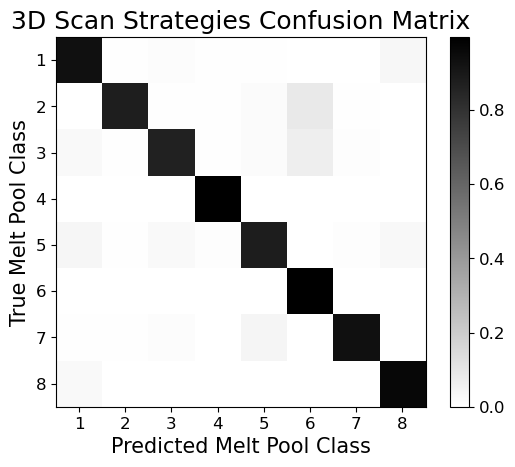

In [24]:
font = {'size'   : 12, 'weight': 'normal', 'family': 'DejaVu Sans'}
plt.rc('font', **font)

# Plot the confusion matrix
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ground_truth, predicted, include_values=False,
                                                              normalize='true', display_labels=range(1,NUM_MELT_POOL_CLASSES+1),
                                                              xticks_rotation='horizontal', cmap='binary')
plt.title('3D Scan Strategies Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Melt Pool Class', fontsize=15)
plt.ylabel('True Melt Pool Class', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../Plots/ConfusionMatrix_Final_LowRes.png', dpi=150, bbox_inches='tight')
plt.savefig('../Plots/ConfusionMatrix_Final.png', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
disp